Este notebook contiene los códigos para las diferentes visualizaciones pedidas en el objetivo 3.

In [1]:
# importación de todas las librerías necesarias en el archivo
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Carga del conjunto de datos
data = pd.read_csv('../data/access/parkings_access.csv')
data.head()

,Unnamed: 0,aparcamiento_id,variacion_diaria,variacion_semanal,nombre_x,latitud_x,longitud_x
0,0,1,73.1,73.1,Aparcamiento Plaza Mayor,40.4155,-3.7074
1,1,2,73.0,73.0,Aparcamiento Centro,40.4162,-3.7069
2,2,3,73.1,73.1,Aparcamiento Las Cortes,40.4147,-3.6999
3,3,4,72.0,72.0,Aparcamiento Recoletos,40.4217,-3.6909
4,4,5,76.0,76.0,Aparcamiento Chueca,40.4235,-3.6984


Calculamos las correlaciones de cada aparcamiento con la variación diaria y semanal. Guardamos la información en dos Dataframes diferentes.

In [3]:
# Aplica One-Hot Encoding a la columna 'nombre_x'
one_hot_encoded = pd.get_dummies(data['nombre_x'])

# Concatena las columnas One-Hot Encoding al DataFrame original
data = pd.concat([data, one_hot_encoded], axis=1)

# Calcula la correlación entre cada columna One-Hot Encoding y 'variacion_diaria' y 'variacion_semanal'
correlaciones_diarias = []
correlaciones_semanales = []

for column in one_hot_encoded.columns:
    # Obtener la primera latitud y longitud asociada a ese nombre
    row = data[data['nombre_x'] == column].iloc[0]
    lat = row['latitud_x']
    lon = row['longitud_x']
    # Calcular correlaciones
    corr_diaria = data[column].corr(data['variacion_diaria'])
    corr_semanal = data[column].corr(data['variacion_semanal'])
    # Guardar resultados
    correlaciones_diarias.append({'nombre': column, 'latitud': lat, 'longitud': lon, 'correlacion': corr_diaria})
    correlaciones_semanales.append({'nombre': column, 'latitud': lat, 'longitud': lon, 'correlacion': corr_semanal})

# Crear los DataFrames
df_corr_diaria = pd.DataFrame(correlaciones_diarias)
df_corr_semanal = pd.DataFrame(correlaciones_semanales)

print("DataFrame de correlaciones diarias:")
print(df_corr_diaria.head())

print("\nDataFrame de correlaciones semanales:")
print(df_corr_semanal.head())


DataFrame de correlaciones diarias:
                         nombre  latitud  longitud  correlacion
0  Aparcamiento Alonso Martínez  40.4294   -3.6960     0.215318
1         Aparcamiento Bernabéu  40.4532   -3.6883     0.153207
2       Aparcamiento Castellana  40.4326   -3.6904     0.028985
3           Aparcamiento Centro  40.4162   -3.7069    -0.219458
4         Aparcamiento Chamberí  40.4354   -3.7031    -0.219458

DataFrame de correlaciones semanales:
                         nombre  latitud  longitud  correlacion
0  Aparcamiento Alonso Martínez  40.4294   -3.6960     0.215318
1         Aparcamiento Bernabéu  40.4532   -3.6883     0.153207
2       Aparcamiento Castellana  40.4326   -3.6904     0.028985
3           Aparcamiento Centro  40.4162   -3.7069    -0.219458
4         Aparcamiento Chamberí  40.4354   -3.7031    -0.219458


Generamos una función que dibujará sobre una imagen de la zona con los aparcamientos marcados un mapa de calor en el que el color del punto sobre cada parking indicará la correlación con la variación correspondiente. Dibujamos en cada parking guiándonos de las coordenadas de latitud y longitud de estos.

In [4]:
def draw_correlation_heatmap(df_corr, title):
    minx, maxx = -3.7074, -3.6839
    miny, maxy = 40.4143, 40.4532
    margx = 0.0015
    margy = 0.0015
    
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)
    
    # Configurar ejes
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    ax.set_xlim(minx-margx, maxx+margx)
    ax.set_ylim(miny-margy, maxy+margy)
    
    # Cargar imagen de Madrid como fondo
    img = plt.imread("mapa_estaciones.jpg")
    plt.imshow(img, extent=[minx-margx, maxx+margx, miny-margy, maxy+margy], aspect='auto', alpha=0.7)
    
    # Dibujar puntos coloreados según valor de correlación
    scatter = plt.scatter(
        df_corr['longitud'], df_corr['latitud'],
        c=df_corr['correlacion'], cmap='coolwarm',
        s=400,  # Puntos grandes
        alpha=0.8, edgecolor='black'
    )
    
    # Añadir número al lado de cada punto y preparar la leyenda
    leyenda = []
    for idx, row in df_corr.reset_index(drop=True).iterrows():
        numero = idx + 1  # Para empezar en 1
        ax.annotate(
            str(numero),
            (row['longitud'], row['latitud']),
            textcoords="offset points",
            xytext=(11, -15),  # Desplaza el texto 11 puntos a la derecha y 15 hacia abajo
            ha='left',
            fontsize=13,
            color='black',
            weight='bold'
        )
        leyenda.append(f"{numero}: {row['nombre']}")
    
    # Añadir barra de color
    cbar = plt.colorbar(scatter)
    cbar.set_label('Correlación')
    
    plt.title(title)
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Deja espacio a la derecha para la leyenda
    
    # Añadir la leyenda a la derecha del gráfico
    leyenda_texto = "\n".join(leyenda)
    plt.gcf().text(0.82, 0.5, "Correspondencia índices-aparcamientos:\n" + leyenda_texto, fontsize=10, va='center', ha='left', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.show()

Por último, creamos una función que nos ayudará a obtener una visualización de la relación entre variación diaria y semanal.

In [5]:
def relacion_variaciones(data): 
    # Configuración inicial para visualización clara
    sns.set_style("whitegrid")

    # Crear una columna de índices para numerar los aparcamientos
    data = data.copy()
    data = data.reset_index(drop=True)
    data['indice'] = data.index + 1  # Para empezar en 1

    # Agrupar por coordenadas y juntar los índices
    agrupado = data.groupby(['variacion_diaria', 'variacion_semanal'])['indice'].apply(lambda x: ','.join(map(str, x))).reset_index()

    # Creación del gráfico de dispersión
    fig = plt.figure(figsize=(14, 8))
    ax = plt.gca()
    scatter = sns.scatterplot(
        data=data,
        x='variacion_diaria',
        y='variacion_semanal',
        hue='nombre_x',
        s=200,
        alpha=0.8,
        edgecolor='w',
        linewidth=0.5,
        ax=ax
    )

    # Poner el/los número(s) al lado de cada punto
    for _, row in agrupado.iterrows():
        ax.annotate(
            row['indice'],
            (row['variacion_diaria'], row['variacion_semanal']),
            textcoords="offset points",
            xytext=(7, 0),
            ha='left',
            fontsize=10,
            color='black',
            weight='bold'
        )

    # Crear la leyenda personalizada de índice-nombre
    leyenda = [f"{row['indice']}: {row['nombre_x']}" for _, row in data.iterrows()]
    leyenda_texto = "Leyenda:\n" + "\n".join(leyenda)
    # Ajusta la posición según tu preferencia
    plt.gcf().text(0.9, 0.5, leyenda_texto, fontsize=10, va='center', ha='left', bbox=dict(facecolor='white', alpha=0.7))
    
    # Personalización 
    plt.title('Relación entre variaciones diarias y semanales de ocupación', pad=20, fontsize=16)
    plt.xlabel('Variación diaria (%) → Mayor fluctuación durante el día', fontsize=12)
    plt.ylabel('Variación semanal (%) → Mayor fluctuación entre días', fontsize=12)
    plt.legend([],[], frameon=False)  # Oculta la leyenda automática de seaborn

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Deja espacio a la derecha para la leyenda
    plt.show()

---

Con todo ello, generamos el informe completo: 


Análisis de variaciones (Actualizado: 07/05/2025 || 10:18):

Los aparcamamientos con mayor variabilidad son:
- Aparcamiento Tribunal (Variación diaria: 76.19999999999999%)
- Aparcamiento Tribunal (Variación semanal: 76.19999999999999%)

Y la relación entre ambas variaciones: 


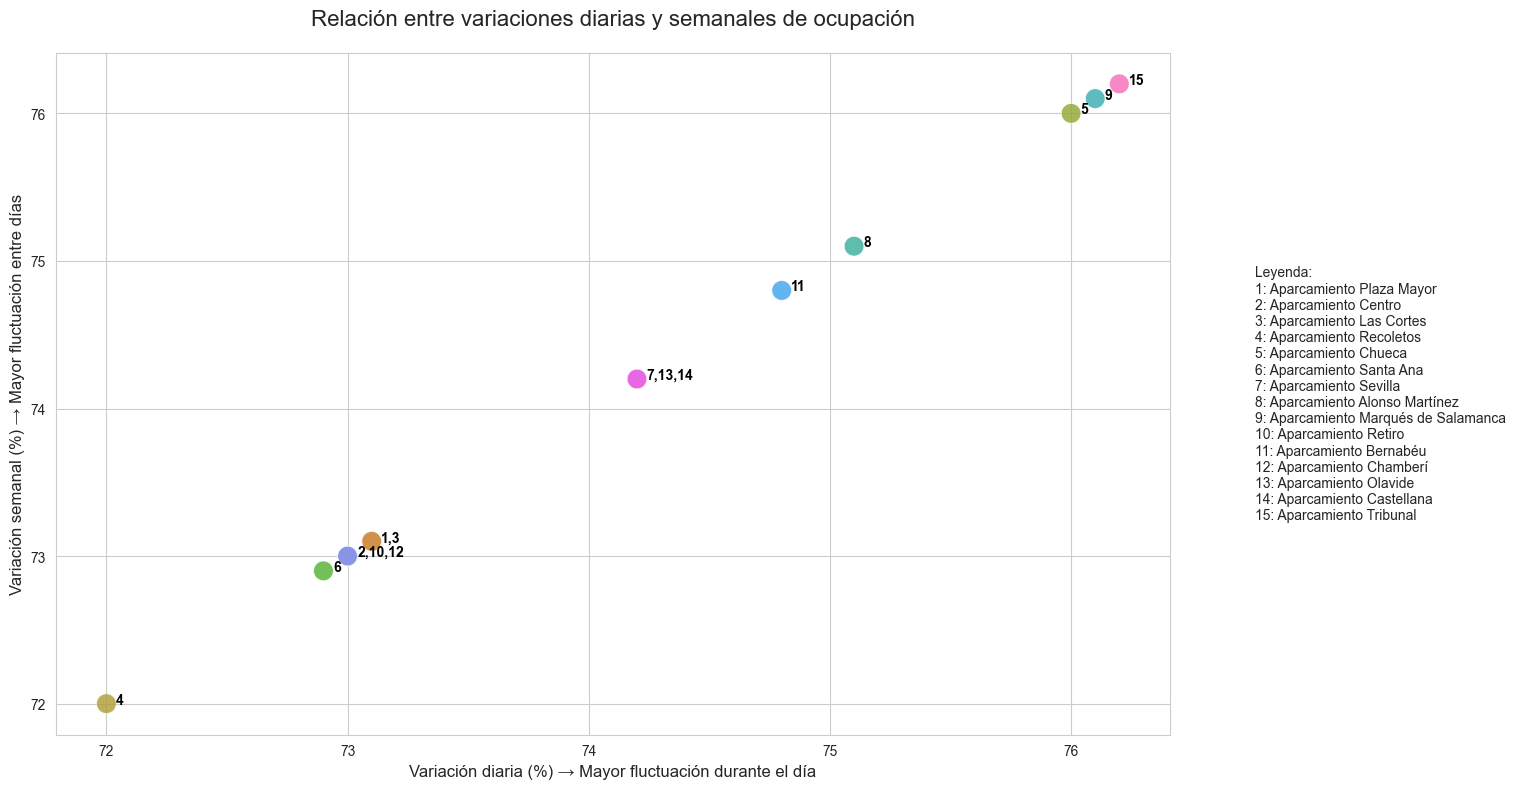


De la que podemos obtener diferente información: 
- Los puntos (aparcamientos) que estén más a la izquierda cuentan con una variación diaria más baja; y de la misma forma los que estén más a la derecha con una variación diaria más alta.
- Los puntos (aparcamientos) que estén más abajo cuentan con una variación semanal más baja; y de la misma forma los que estén más arriba con una variación semanal más alta. 

Y viendo la posición da cada aparcamiento podemos relacionar si un aparcamiento tiene una variación diaria baja pero una variación semanal más alta, o una variación diaria más alta 
mientras que una variación semanal más baja, o ambas variaciones diaria y semanal altas/bajas, etc. 
      
Además, en cuanto a la correlación entre la ubicación de los aparcamientos y su variación semanal y diaria obtenemos dos gráficos diferentes.



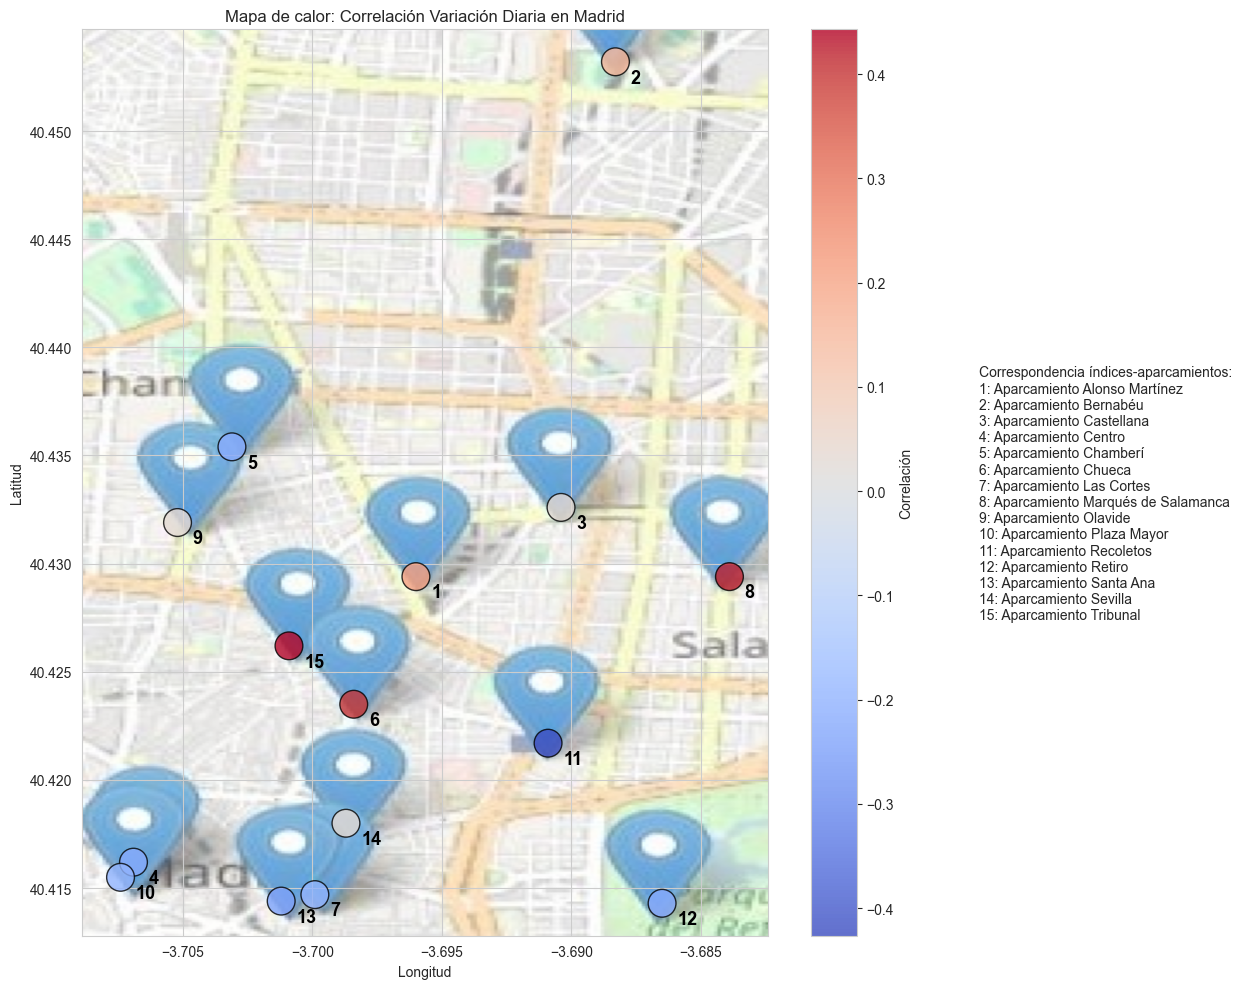

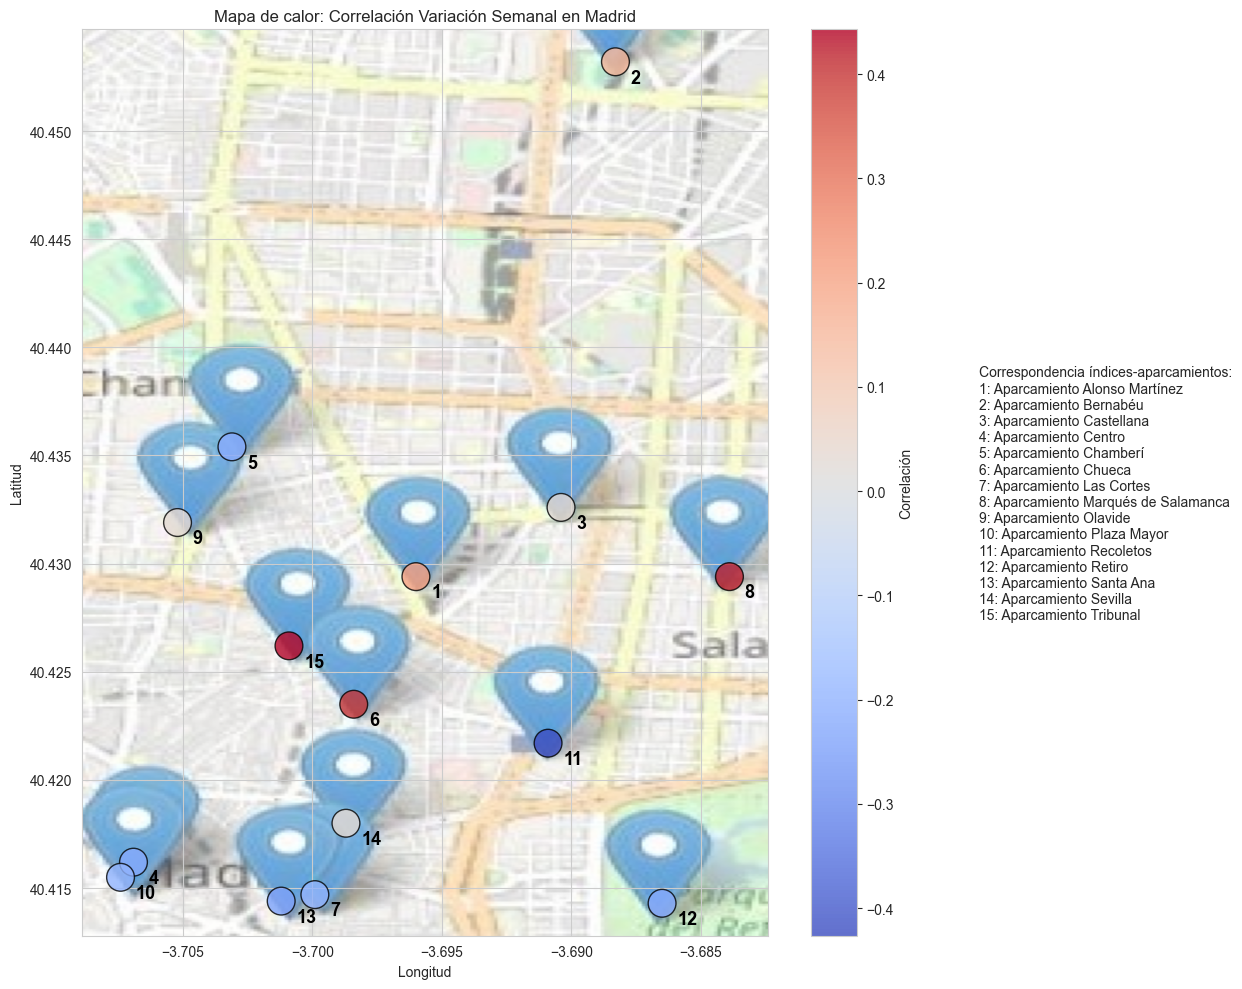


Se define correlación en cuánto una columna define la otra, es decir, cuánto de relacionado está que en una columna aparezca un valor para el valor de la otra. Con ello, para este 
gráfico se calcula la correlación como la tendencia de la variación cuando hablamos de un aparcamiento determinado, es decir: 

- Una correlación positiva significará que en ese aparcamiento la variación (ya sea diaria o semanal) tiene a ser alta; cuanto más cercano sea el valor de la correlación a 1.00 mayor 
será la variación. 
- Una correlación negativa significará que en ese aparcamiento la variación (ya sea diaria o semanal) tiene a ser baja; cuanto más cercano sea el valor de la correlación a -1.00 menor 
será la variación. 
      
Podemos ver entonces en los gráficos el nivel de correlación de cada aparcamiento en forma de mapa de calor; cuanto más rojo/caliente mayor correlación, y cuanto más azul/frio menor 
correlación. Podemos ver la relación de posición de cada aparcamiento con la tendencia de s

In [6]:
# Almacenamos valores extremos 
max_var = data.loc[data['variacion_diaria'].idxmax()]

# Generación de informe automático
print(f"""
Análisis de variaciones (Actualizado: {pd.Timestamp.now().strftime('%d/%m/%Y || %H:%M')}):

Los aparcamamientos con mayor variabilidad son:
- {max_var['nombre_x']} (Variación diaria: {max_var['variacion_diaria']}%)
- {data.loc[data['variacion_semanal'].idxmax()]['nombre_x']} (Variación semanal: {data['variacion_semanal'].max()}%)

Y la relación entre ambas variaciones: """)

# Dibujar el gráfico de relación entre variaciones
relacion_variaciones(data)

print(f"""
De la que podemos obtener diferente información: 
- Los puntos (aparcamientos) que estén más a la izquierda cuentan con una variación diaria más baja; y de la misma forma los que estén más a la derecha con una variación diaria más alta.
- Los puntos (aparcamientos) que estén más abajo cuentan con una variación semanal más baja; y de la misma forma los que estén más arriba con una variación semanal más alta. 

Y viendo la posición da cada aparcamiento podemos relacionar si un aparcamiento tiene una variación diaria baja pero una variación semanal más alta, o una variación diaria más alta 
mientras que una variación semanal más baja, o ambas variaciones diaria y semanal altas/bajas, etc. 
      
Además, en cuanto a la correlación entre la ubicación de los aparcamientos y su variación semanal y diaria obtenemos dos gráficos diferentes.
""")

# Dibujar mapa de calor para correlaciones diarias
draw_correlation_heatmap(df_corr_diaria, 'Mapa de calor: Correlación Variación Diaria en Madrid')

# Dibujar mapa de calor para correlaciones semanales
draw_correlation_heatmap(df_corr_semanal, 'Mapa de calor: Correlación Variación Semanal en Madrid')

print(f"""
Se define correlación en cuánto una columna define la otra, es decir, cuánto de relacionado está que en una columna aparezca un valor para el valor de la otra. Con ello, para este 
gráfico se calcula la correlación como la tendencia de la variación cuando hablamos de un aparcamiento determinado, es decir: 

- Una correlación positiva significará que en ese aparcamiento la variación (ya sea diaria o semanal) tiene a ser alta; cuanto más cercano sea el valor de la correlación a 1.00 mayor 
será la variación. 
- Una correlación negativa significará que en ese aparcamiento la variación (ya sea diaria o semanal) tiene a ser baja; cuanto más cercano sea el valor de la correlación a -1.00 menor 
será la variación. 
      
Podemos ver entonces en los gráficos el nivel de correlación de cada aparcamiento en forma de mapa de calor; cuanto más rojo/caliente mayor correlación, y cuanto más azul/frio menor 
correlación. Podemos ver la relación de posición de cada aparcamiento con la tendencia de su variación al estar cada punto ubicado sobre su correspondiente aparcamiento (coordenadas 
de latitud y longitud) e indicado su debido nombre. 
""")
